# Assignment #5: Sales prediction with ARIMA

Karim Kanji
IA-20


---



In [17]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Full_Sales_Data_For_ARIMA_Monthly_Predictions (1).csv to Full_Sales_Data_For_ARIMA_Monthly_Predictions (1).csv


In [5]:
sales_data = pd.read_csv('Full_Sales_Data_For_ARIMA_Monthly_Predictions.csv')
sales_data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICE_EACH (After Discount),CUSTOMER_TYPE,GROSS_SALES_VALUE,Date_Of_Sale (mm-dd-yyyy),STATUS,QTR_ID_of_Order,MONTH_ID_Of_Order,YEAR_Of_Order,CUSTOMERNAME,PHONE,CITY,POSTALCODE,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,Customer_Company_Size
0,10100,46,100.00,3,4600,01-06-2003,Shipped,1,1,2003,Online Diecast Creations Co.,6035558647,Nashua,62005,USA,Young,Valarie,Medium
1,10100,66,67.80,2,4475,01-06-2003,Shipped,1,1,2003,Online Diecast Creations Co.,6035558647,Nashua,62005,USA,Young,Valarie,Medium
2,10100,38,86.51,4,3287,01-06-2003,Shipped,1,1,2003,Online Diecast Creations Co.,6035558647,Nashua,62005,USA,Young,Valarie,Small
3,10100,65,34.47,1,2241,01-06-2003,Shipped,1,1,2003,Online Diecast Creations Co.,6035558647,Nashua,62005,USA,Young,Valarie,Small
4,10101,41,100.00,4,4100,01-09-2003,Shipped,1,1,2003,"Blauer See Auto, Co.",+49 69 66 90 2555,Frankfurt,60528,Germany,Keitel,Roland,Medium


### Task 1:

   Date_Of_Sale (mm-dd-yyyy)  QUANTITYORDERED
0                 2003-01-31             1981
1                 2003-02-28             2761
2                 2003-03-31             4155
3                 2003-04-30             5705
4                 2003-05-31             6657
5                 2003-06-30             6065
6                 2003-07-31             7325
7                 2003-08-31             9398
8                 2003-09-30            13454
9                 2003-10-31            15943
10                2003-11-30            22019
11                2003-12-31            15929
12                2004-01-31            22173
13                2004-02-29            22325
14                2004-03-31            21178
15                2004-04-30            21206
16                2004-05-31            22746
17                2004-06-30            27451
18                2004-07-31            30838
19                2004-08-31            35021
20                2004-09-30      

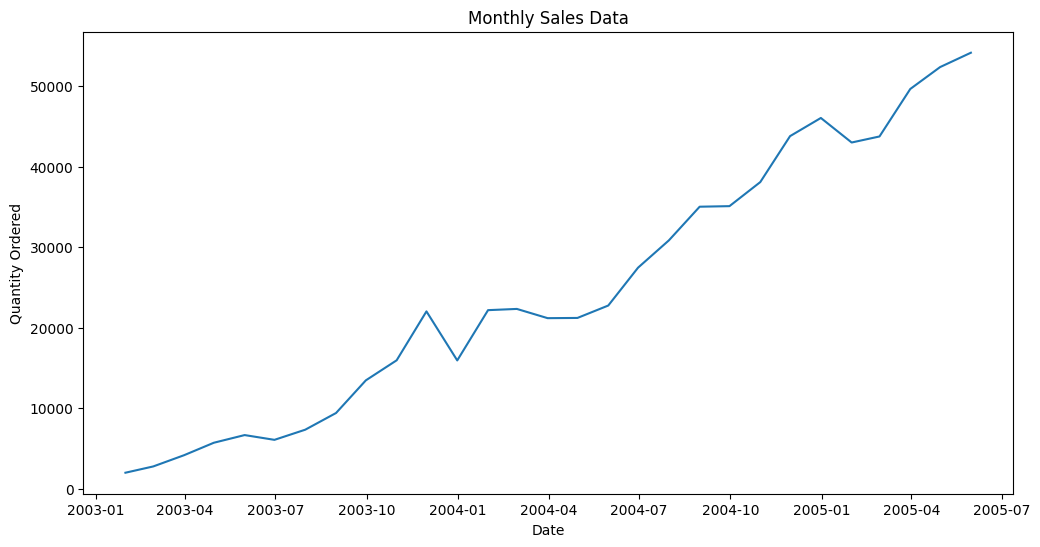

In [19]:
sales_data['Date_Of_Sale (mm-dd-yyyy)'] = pd.to_datetime(sales_data['Date_Of_Sale (mm-dd-yyyy)'])
monthly_sales_data = sales_data.groupby(pd.Grouper(key='Date_Of_Sale (mm-dd-yyyy)', freq='M'))['QUANTITYORDERED'].sum().reset_index()
print(monthly_sales_data)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(monthly_sales_data['Date_Of_Sale (mm-dd-yyyy)'], monthly_sales_data['QUANTITYORDERED'])
ax.set_title('Monthly Sales Data')
ax.set_xlabel('Date')
ax.set_ylabel('Quantity Ordered')

plt.show()

The previous code extracted the meaningful value of the data, by showing us the Date of Sale and the quantity that was ordered that month.

# Task 2:

In [7]:
monthly_sales_data.head()


,Date_Of_Sale (mm-dd-yyyy),QUANTITYORDERED
0,2003-01-31,1981
1,2003-02-28,2761
2,2003-03-31,4155
3,2003-04-30,5705
4,2003-05-31,6657


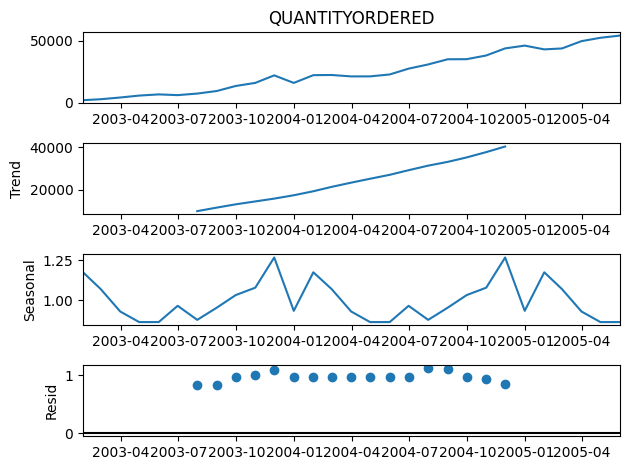

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the index of the DataFrame to the Date_Of_Sale column
monthly_sales_data = monthly_sales_data.set_index('Date_Of_Sale (mm-dd-yyyy)')

# Create a time series object
ts = monthly_sales_data['QUANTITYORDERED']

# Perform seasonal decomposition
result = seasonal_decompose(ts, model='multiplicative', period=12)


# Plot the decomposition
result.plot()
plt.show()

From the plot, we can see that there is a clear upward trend in the data, and there also appears to be some seasonality with a period of 12 months.


# Task 3:

Next, we can calculate the ARIMA parameters manually. To do this, we first need to determine the order of differencing required to make the time series stationary. We can do this by performing the Augmented Dickey-Fuller (ADF) test using the adfuller() function from the statsmodels library.

In [22]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_sales_data['QUANTITYORDERED'])

print('ADF Statistic: ', result[0])
print('p-value: ', result[1])


ADF Statistic:  2.38315341706971
p-value:  0.9990021598145198


Since the p-value is greater than 0.05, we cannot reject the null hypothesis that the time series is non-stationary. This suggests that we need to difference the data.

ADF Statistic:  -6.30303673765846
p-value:  3.375495040110921e-08


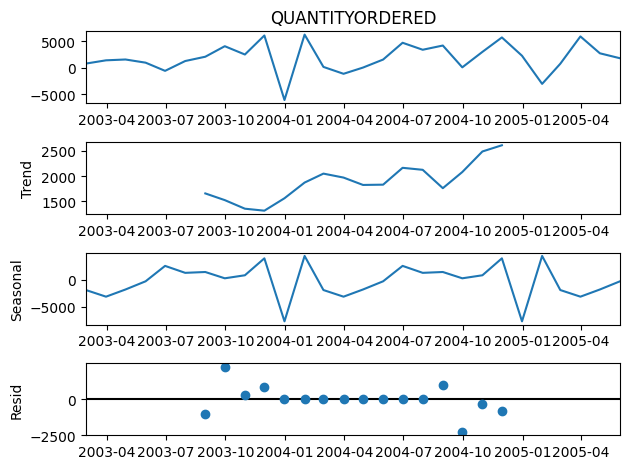

In [23]:
# the first difference of the time series
diff1 = monthly_sales_data.diff().dropna()

result = adfuller(diff1['QUANTITYORDERED'])

print('ADF Statistic: ', result[0])
print('p-value: ', result[1])



result = seasonal_decompose(diff1['QUANTITYORDERED'], model='additive', period=12)

result.plot()
plt.show()

From this we can see that the first difference suggests that the time series is now stationary since the p-value is significantly lower than 0.05 however, upon inspection using decomposition we can still se a clear, visible trend. Another porblem is also that the p-value is so significantly lower than 0.05 it indicates overdifferentiated. The scenario we have encountered is one where the p-value is indicating stationarity but visual inspection is clearly indicating non-stationarity. This could mean there is a long-term trend component that needs to be accounted for. For this we can use other detrending techniques such as moving average.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


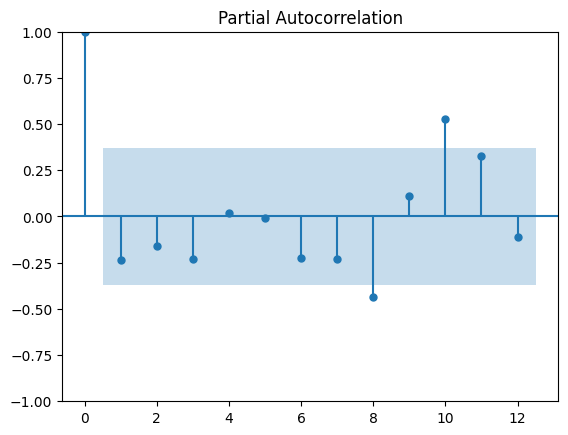

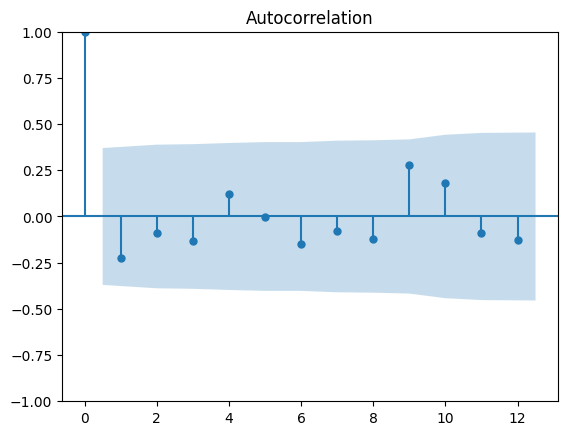

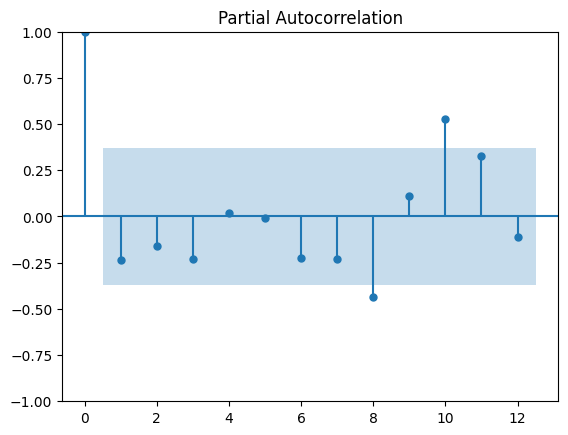

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Plot ACF
plot_acf(diff1['QUANTITYORDERED'].dropna(), lags=12)

# Plot PACF
plot_pacf(diff1['QUANTITYORDERED'].dropna(), lags=12)


There seems to be a sharp drop-off between the first datapoint and the second, this indicates a value of 1 in the ACF plot. The PACF drop-off is similar indicating a value of 1. This gives us the PDQ values of 1, 1 and 1

In [34]:
from statsmodels.tsa.arima.model import ARIMA


# Fit the ARIMA model with PDQ values of 1,1,1
model = SARIMAX(monthly_sales_data, order=(1,1,1))
results = model.fit()

# Generate predicted values for the next 12 months
forecast = results.predict(start=len(monthly_sales_data), end=len(monthly_sales_data)+11, dynamic=True)

manual_prediction = results.predict(start='2005-06-01', end='2005-08-01', dynamic=True)
print(manual_prediction)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


2005-06-30    55909.244561
2005-07-31    57671.464775
2005-08-31    59433.660643
Freq: M, Name: predicted_mean, dtype: float64


# Task 4:

In [26]:
!pip install pmdarima
from pmdarima.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.6 MB/s eta 0:00:00


In [35]:


model_autoARIMA = auto_arima(monthly_sales_data['QUANTITYORDERED'])
auto_modelResult = model_autoARIMA.fit(monthly_sales_data)
print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -260.093
Date:                Mon, 08 May 2023   AIC                            526.185
Time:                        16:36:43   BIC                            530.182
Sample:                    01-31-2003   HQIC                           527.407
                         - 05-31-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1846.1336    355.650      5.191      0.000    1149.073    2543.195
ma.L1         -0.3461      0.186     -1.860      0.063      -0.711       0.019
sigma2       6.99e+06   2.57e+06      2.715      0.0

In [38]:
auto_prediction = auto_modelResult.predict(n_periods=3)
print(auto_prediction)

2005-06-30    55778.742277
2005-07-31    57624.875892
2005-08-31    59471.009507
Freq: M, dtype: float64


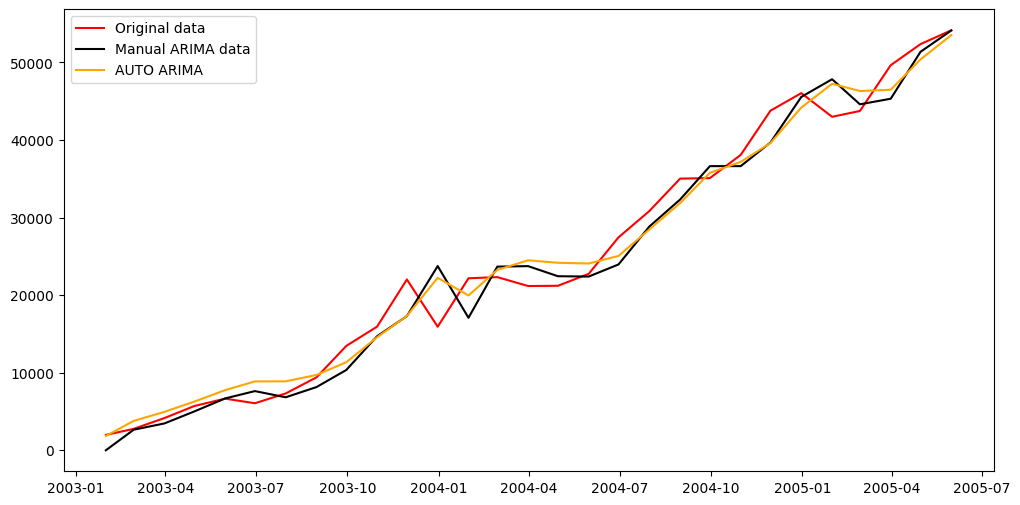

In [46]:
plt.figure(figsize=(12,6))
plt.plot(monthly_sales_data, label='Original data', color="red")
plt.plot(results.fittedvalues, label='Manual ARIMA data', color="black")
plt.plot(auto_modelResult.predict_in_sample(), label='AUTO ARIMA', color="orange")
plt.legend()
plt.show()

